<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Course4/Practice/Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-01-01 07:38:33--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2021-01-01 07:38:33 (42.2 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



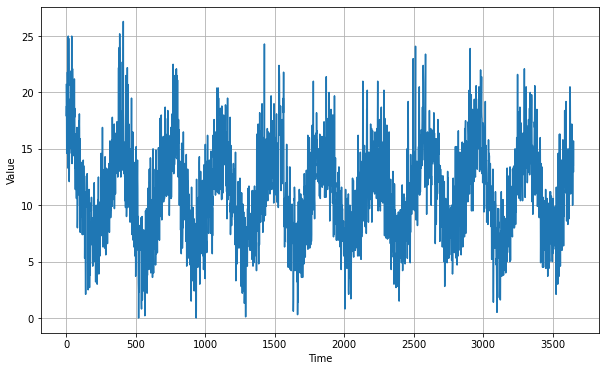

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for i, row in enumerate(reader):
        time_step.append(i+1)
        temps.append(float(row[1]))
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
from tensorflow import keras

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal",
                        activation="relu", input_shape=[None, 1]),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 29ms/step - loss: 37.4632 - mae: 37.9632
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 37.4253 - mae: 37.9253
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 37.2705 - mae: 37.7705
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 37.0134 - mae: 37.5134
Epoch 5/100
10/10 [==============================] - 1s 31ms/step - loss: 36.7849 - mae: 37.2849
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 36.5692 - mae: 37.0692
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 36.4259 - mae: 36.9259
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 36.0921 - mae: 36.5921
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - loss: 35.8027 - mae: 36.3027
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

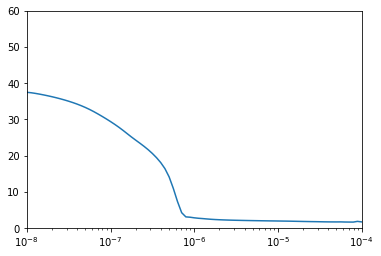

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=5, padding="causal",
                        activation="relu", input_shape=[None, 1]),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*100)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 3s 15ms/step - loss: 17.0475 - mae: 17.5401
Epoch 2/150
25/25 [==============================] - 0s 13ms/step - loss: 2.2121 - mae: 2.6718
Epoch 3/150
25/25 [==============================] - 0s 12ms/step - loss: 1.8312 - mae: 2.2836
Epoch 4/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7448 - mae: 2.1948
Epoch 5/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7316 - mae: 2.1821
Epoch 6/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7042 - mae: 2.1539
Epoch 7/150
25/25 [==============================] - 0s 12ms/step - loss: 1.6938 - mae: 2.1440
Epoch 8/150
25/25 [==============================] - 0s 13ms/step - loss: 1.6787 - mae: 2.1277
Epoch 9/150
25/25 [==============================] - 1s 15ms/step - loss: 1.6755 - mae: 2.1246
Epoch 10/150
25/25 [==============================] - 0s 13ms/step - loss: 1.6529 - mae: 2.1012
Epoch 11/150
25/25 [===========================

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

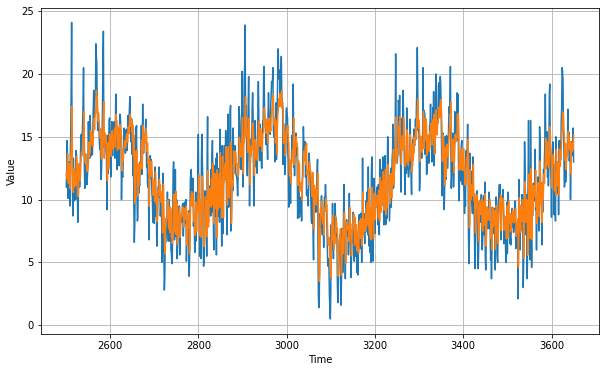

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7878698

In [18]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.015974  11.663761  12.746745  ... 13.9262705 13.983975  15.140303 ]
